In [1]:
import sys, os

import warnings
warnings.filterwarnings('ignore')

# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd

from PIL import Image
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D,UpSampling2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape,ZeroPadding2D,Input,Activation
import tensorflow as tf

## Loading and pre-processing audio data:

In [2]:
general_songs_path = r'C:\Users\weldl\Datasets\gtzan-dataset-music-genre-classification'
genres_list = os.listdir(f'{general_songs_path}/genres_original/')
print(genres_list)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [3]:
all_songs = []
for genre in genres_list:
    for song_name in os.listdir(os.path.join(f'{general_songs_path}/genres_original/', genre)):
        all_songs.append(os.path.join(f'{general_songs_path}/genres_original/', genre, song_name))
print('all_songs:', len(all_songs))

all_songs: 1000


In [4]:
def get_spectogram_data(songs_array):
    spec_array = []
    for song_name in songs_array:
        y, sr = librosa.load(song_name)
        y, _ = librosa.effects.trim(y)
        S = librosa.feature.melspectrogram(y, sr=sr)
        S_DB = (librosa.amplitude_to_db(S, ref=np.max)+80)/80
        try:
            spec_array.append(S_DB[:, 0:1210].reshape((128, 1210, 1)))
        except ValueError:
            print(S_DB.shape)
    return np.array(spec_array)

spec_data = get_spectogram_data(all_songs[:])
print(spec_data[0].min(), spec_data[0].max())
spec_data.shape

0.0 1.0


(1000, 128, 1210, 1)

In [5]:
SPEC_SHAPE = spec_data.shape[1:]

In [6]:
spec_data_train, spec_data_test = train_test_split(spec_data, test_size=0.1, random_state=42)

print('train samples:', spec_data_train.shape)
print('test samples:', spec_data_test.shape)

train samples: (900, 128, 1210, 1)
test samples: (100, 128, 1210, 1)


## Loading and pre-processing images:

In [7]:
# general_imgs_path = r'C:\Users\weldl\Datasets\Album Covers Images'
general_imgs_path = r'C:\Users\weldl\Datasets\Album Covers Images Sample'

for dirname, _, filenames in os.walk(general_imgs_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\weldl\Datasets\Album Covers Images Sample\0 - Copia (10) - Copia - Copia - Copia - Copia - Copia - Copia - Copia - Copia - Copia.jpg
C:\Users\weldl\Datasets\Album Covers Images Sample\0 - Copia (10) - Copia - Copia - Copia - Copia - Copia - Copia - Copia - Copia.jpg
C:\Users\weldl\Datasets\Album Covers Images Sample\0 - Copia (10) - Copia - Copia - Copia - Copia - Copia - Copia - Copia.jpg
C:\Users\weldl\Datasets\Album Covers Images Sample\0 - Copia (10) - Copia - Copia - Copia - Copia - Copia - Copia.jpg
C:\Users\weldl\Datasets\Album Covers Images Sample\0 - Copia (10) - Copia - Copia - Copia - Copia - Copia.jpg
C:\Users\weldl\Datasets\Album Covers Images Sample\0 - Copia (10) - Copia - Copia - Copia - Copia.jpg
C:\Users\weldl\Datasets\Album Covers Images Sample\0 - Copia (10) - Copia - Copia - Copia.jpg
C:\Users\weldl\Datasets\Album Covers Images Sample\0 - Copia (10) - Copia - Copia.jpg
C:\Users\weldl\Datasets\Album Covers Images Sample\0 - Copia (10) - Copia.jpg
C:\Users\w

In [8]:
imgs_paths = []
for path in os.listdir(general_imgs_path):
    if '.jpg' in path:
        imgs_paths.append(os.path.join(general_imgs_path, path))

In [9]:
imgs_paths_train = imgs_paths[0:1000]
len(imgs_paths_train)

1000

In [10]:
IMG_SHAPE = (64, 64)

# crop = (30, 55, 150, 175) #croping size for the image so that only the face at centre is obtained
# images = [np.array((Image.open(path).crop(crop)).resize((64,64))) for path in new_path]
images = [np.array(Image.open(path).resize(IMG_SHAPE)) for path in imgs_paths_train]

for i in range(len(images)):
#     images[i] = ((images[i] - images[i].min())/(255 - images[i].min()))
    images[i] = ((images[i] - 127.5)/127.5)
    #images[i] = images[i]*2-1  #uncomment this if activation is tanh for generator last layer

images = np.array(images)
print(images.min(), images.max())

-1.0 0.984313725490196


In [11]:
train_data=images
train_data.shape

(1000, 64, 64, 3)

In [12]:
IMG_SHAPE = train_data.shape[1:]
IMG_SHAPE

(64, 64, 3)

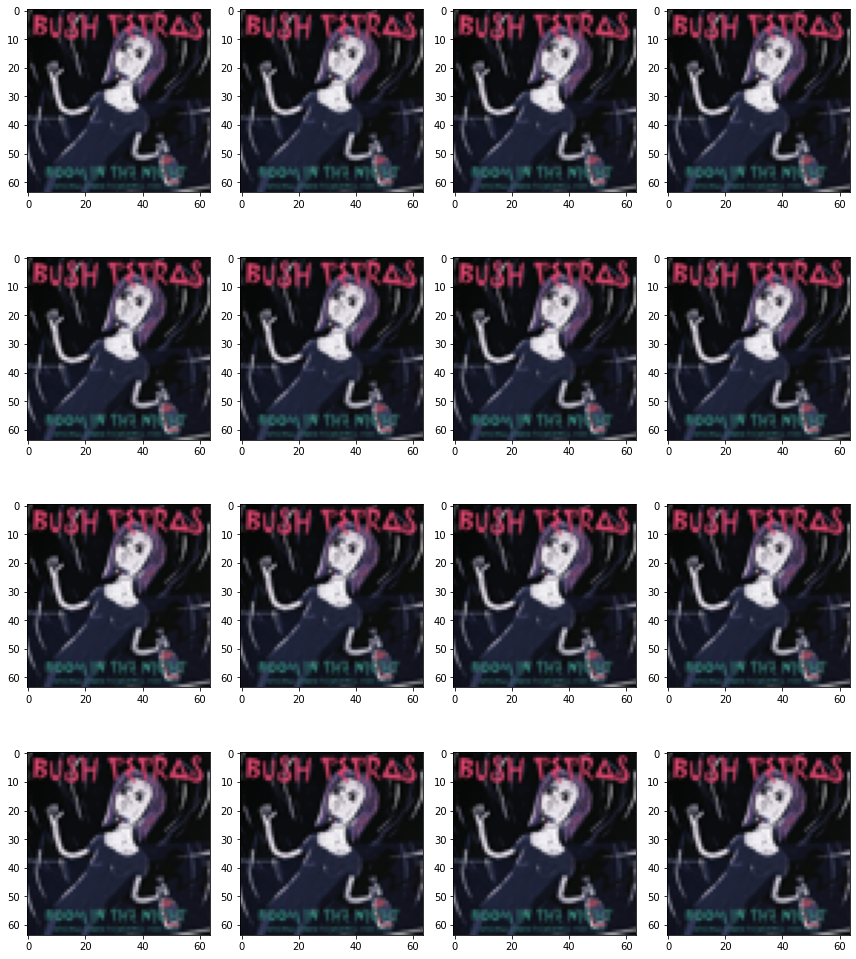

In [13]:
# Images Visualization:
   
def plot_img_samples(img_array, figsize=(12, 14), title=None, subplot_dim=(4, 4)):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    idx=0
    for i in range(subplot_dim[0]):
        for j in range(subplot_dim[1]):
                plt.subplot(subplot_dim[0], subplot_dim[1], i*4 + j +1)
                img_array_ = (img_array[idx]+1) * 127.5
                plt.imshow(img_array_.astype(int))
                idx+=1
    plt.tight_layout()
    plt.show()

plot_img_samples(train_data)

In [14]:
X_train = train_data
X_train.shape

(1000, 64, 64, 3)

# **Generator**

In [15]:
noise_shape = 100

In [16]:
# def make_encoder_model(input_shape=(64,64, 3), output_len=100):
#     encoder = Sequential()
#     encoder.add(Conv2D(32, (3,3), strides=(2, 2), padding='same', input_shape=input_shape))
#     encoder.add(Conv2D(16, (3,3), strides=(2, 2), padding='same'))
#     encoder.add(Conv2D(16, (3,3), strides=(2, 2), padding='same'))
#     encoder.add(Conv2D(8, (3,3), strides=(2, 2), padding='same'))
#     encoder.add(Flatten())
#     encoder.add(Dropout(0.3))
#     encoder.add(Dense(256))
#     encoder.add(Dense(output_len))
#     return encoder

# encoder = make_encoder_model(input_shape=SPEC_SHAPE, output_len=noise_shape)
# encoder.summary()

In [17]:
def make_encoder_model(input_shape=(64,64, 3), output_len=100):
    encoder = Sequential()
    encoder.add(Conv2D(32, (3,3), strides=(2, 2), padding='same', input_shape=input_shape))
    encoder.add(layers.BatchNormalization())
    encoder.add(Dropout(0.3))
    encoder.add(Conv2D(16, (3,3), strides=(2, 2), padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(Dropout(0.3))
    encoder.add(Conv2D(8, (3,3), strides=(2, 2), padding='same'))
    encoder.add(Flatten())
    encoder.add(layers.BatchNormalization())
    encoder.add(Dropout(0.3))
    encoder.add(Dense(output_len))
    return encoder

encoder = make_encoder_model(input_shape=SPEC_SHAPE, output_len=noise_shape)
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 605, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 605, 32)       128       
_________________________________________________________________
dropout (Dropout)            (None, 64, 605, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 303, 16)       4624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 303, 16)       64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 303, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 152, 8)        1

In [18]:
samples = np.array(encoder(spec_data[0:2]))
print(samples.min(), samples.max())

-0.25358048 0.18298715


In [19]:
def build_generator(noise_size, channels):
    GENERATE_RES=2
    model = Sequential()
    model.add(Dense(4 * 4 * 256, activation="relu", input_dim=noise_size))
    model.add(Reshape((4, 4, 256)))
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    for i in range(GENERATE_RES):
         model.add(UpSampling2D())
         model.add(Conv2D(256, kernel_size=3, padding="same"))
         model.add(BatchNormalization(momentum=0.8))
         model.add(Activation("relu"))
#     model.summary()
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation('tanh'))
#     input = Input(shape=(noise_size,))
#     generated_image = model(input)
    
    return model

generator_ = build_generator(noise_shape, channels=IMG_SHAPE[-1])
generator_.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         590080    
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
activation (Activation)      (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)      

In [20]:
# Adding the encoder to the model:
generator = Sequential([encoder, generator_])
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100)               2029820   
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 3)         2785027   
Total params: 4,814,847
Trainable params: 4,773,791
Non-trainable params: 41,056
_________________________________________________________________


# **Discriminator**

In [21]:
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(32, (3,3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator(IMG_SHAPE)
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

# **DCGAN (combined model)**

In [22]:
GAN = Sequential([generator,discriminator])

In [23]:
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [24]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [25]:
GAN.layers

In [26]:
GAN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 64, 64, 3)         4814847   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 28449     
Total params: 4,843,296
Trainable params: 4,773,791
Non-trainable params: 69,505
_________________________________________________________________


# **Training**

In [27]:
epochs = 30  #set epoch according to your training dataset size,i had chosen 50k images hence epochs are high as 300...
batch_size = 64

In [28]:
D_loss=[] #list to collect loss for the discriminator model
G_loss=[] #list to collect loss for generator model

Currently on Epoch 1
	Currently on batch number 0 of 15


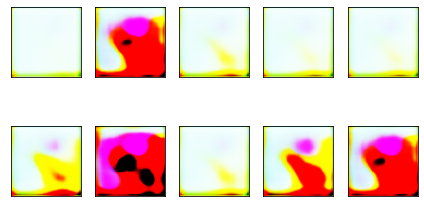

Epoch: 1,  Loss: D_real = 0.077, D_fake = 1.046,  G = 0.326
Currently on Epoch 2
	Currently on batch number 0 of 15
Epoch: 2,  Loss: D_real = 0.021, D_fake = 0.078,  G = 1.710
Currently on Epoch 3
	Currently on batch number 0 of 15
Epoch: 3,  Loss: D_real = 0.036, D_fake = 0.004,  G = 4.795
Currently on Epoch 4
	Currently on batch number 0 of 15
Epoch: 4,  Loss: D_real = 0.010, D_fake = 0.033,  G = 1.885
Currently on Epoch 5
	Currently on batch number 0 of 15
Epoch: 5,  Loss: D_real = 0.016, D_fake = 0.038,  G = 0.533
Currently on Epoch 6
	Currently on batch number 0 of 15


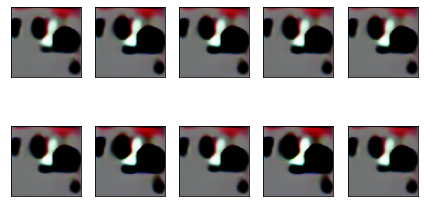

Epoch: 6,  Loss: D_real = 0.063, D_fake = 0.027,  G = 0.921
Currently on Epoch 7
	Currently on batch number 0 of 15
Epoch: 7,  Loss: D_real = 0.021, D_fake = 0.095,  G = 1.696
Currently on Epoch 8
	Currently on batch number 0 of 15
Epoch: 8,  Loss: D_real = 0.006, D_fake = 0.014,  G = 4.732
Currently on Epoch 9
	Currently on batch number 0 of 15
Epoch: 9,  Loss: D_real = 0.184, D_fake = 0.303,  G = 2.103
Currently on Epoch 10
	Currently on batch number 0 of 15
Epoch: 10,  Loss: D_real = 0.123, D_fake = 0.074,  G = 2.505
Currently on Epoch 11
	Currently on batch number 0 of 15


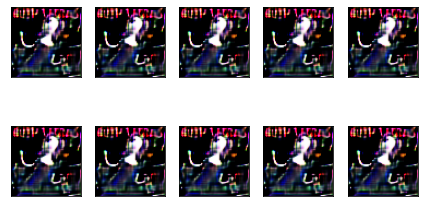

Epoch: 11,  Loss: D_real = 0.166, D_fake = 0.103,  G = 2.864
Currently on Epoch 12
	Currently on batch number 0 of 15
Epoch: 12,  Loss: D_real = 0.261, D_fake = 0.057,  G = 3.952
Currently on Epoch 13
	Currently on batch number 0 of 15
Epoch: 13,  Loss: D_real = 0.074, D_fake = 0.186,  G = 3.000
Currently on Epoch 14
	Currently on batch number 0 of 15
Epoch: 14,  Loss: D_real = 0.356, D_fake = 0.233,  G = 2.437
Currently on Epoch 15
	Currently on batch number 0 of 15
Epoch: 15,  Loss: D_real = 0.367, D_fake = 0.265,  G = 2.202
Currently on Epoch 16
	Currently on batch number 0 of 15


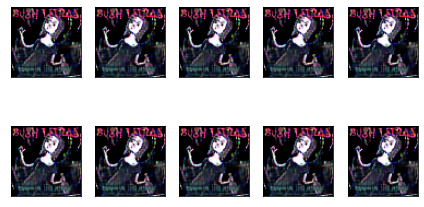

Epoch: 16,  Loss: D_real = 0.219, D_fake = 0.224,  G = 2.328
Currently on Epoch 17
	Currently on batch number 0 of 15
Epoch: 17,  Loss: D_real = 0.172, D_fake = 0.158,  G = 2.136
Currently on Epoch 18
	Currently on batch number 0 of 15
Epoch: 18,  Loss: D_real = 0.135, D_fake = 0.172,  G = 3.269
Currently on Epoch 19
	Currently on batch number 0 of 15
Epoch: 19,  Loss: D_real = 0.772, D_fake = 0.830,  G = 1.449
Currently on Epoch 20
	Currently on batch number 0 of 15
Epoch: 20,  Loss: D_real = 0.619, D_fake = 0.367,  G = 1.574
Currently on Epoch 21
	Currently on batch number 0 of 15


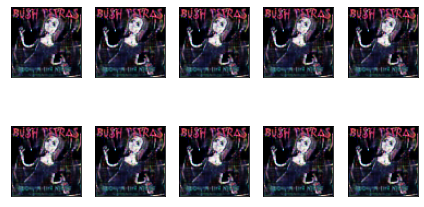

Epoch: 21,  Loss: D_real = 0.481, D_fake = 0.280,  G = 1.866
Currently on Epoch 22
	Currently on batch number 0 of 15
Epoch: 22,  Loss: D_real = 0.397, D_fake = 0.267,  G = 2.028
Currently on Epoch 23
	Currently on batch number 0 of 15
Epoch: 23,  Loss: D_real = 0.403, D_fake = 0.365,  G = 2.044
Currently on Epoch 24
	Currently on batch number 0 of 15
Epoch: 24,  Loss: D_real = 0.162, D_fake = 0.310,  G = 2.121
Currently on Epoch 25
	Currently on batch number 0 of 15
Epoch: 25,  Loss: D_real = 0.015, D_fake = 0.051,  G = 1.313
Currently on Epoch 26
	Currently on batch number 0 of 15


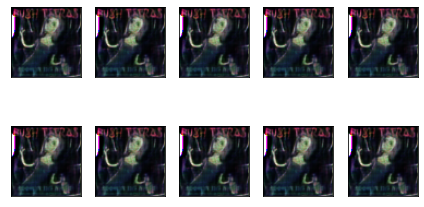

Epoch: 26,  Loss: D_real = 0.101, D_fake = 0.099,  G = 1.263
Currently on Epoch 27
	Currently on batch number 0 of 15
Epoch: 27,  Loss: D_real = 0.089, D_fake = 0.068,  G = 5.057
Currently on Epoch 28
	Currently on batch number 0 of 15
Epoch: 28,  Loss: D_real = 0.037, D_fake = 0.043,  G = 5.039
Currently on Epoch 29
	Currently on batch number 0 of 15
Epoch: 29,  Loss: D_real = 0.018, D_fake = 0.046,  G = 3.027
Currently on Epoch 30
	Currently on batch number 0 of 15
Epoch: 30,  Loss: D_real = 0.028, D_fake = 0.035,  G = 6.159
Currently on Epoch 31
	Currently on batch number 0 of 15


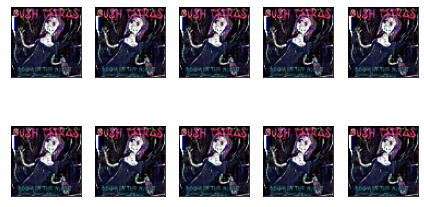

Epoch: 31,  Loss: D_real = 0.013, D_fake = 0.009,  G = 7.474
Currently on Epoch 32
	Currently on batch number 0 of 15


KeyboardInterrupt: 

In [29]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    # For every batch in the dataset
    for i in range(X_train.shape[0]//batch_size):
        
        if (i)%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(X_train)//batch_size}")

        idxs = np.array([i for i in range(spec_data_train.shape[0])])
        idxs_select = np.random.choice(idxs, batch_size)
        img_noise = spec_data_train[idxs_select] #+ np.random.uniform(-0.1, 0.1,size=[batch_size, SPEC_SHAPE[1]])

        gen_image = generator.predict_on_batch(img_noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
        #train on real image
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss1 = discriminator.train_on_batch(train_dataset,train_label)
        
        #train on fake image
        train_label=np.zeros(shape=(batch_size,1))
        d_loss2 = discriminator.train_on_batch(gen_image,train_label)

        idxs = np.array([i for i in range(spec_data_train.shape[0])])
        idxs_select = np.random.choice(idxs, batch_size)
        img_noise = spec_data_train[idxs_select] #+ np.random.uniform(-0.1, 0.1, size=[batch_size, SPEC_SHAPE[1]])

        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        #train the generator
        g_loss = GAN.train_on_batch(img_noise, train_label)
        D_loss.append(d_loss1+d_loss2)
        G_loss.append(g_loss)
        
         
    if epoch % 5 == 0:
        samples = 10
#         test_samples = np.random.normal(loc=0, scale=1, size=(samples,100))        
        idxs = np.array([i for i in range(spec_data_test.shape[0])])
        idxs_select = np.random.choice(idxs, samples)
        test_samples = spec_data_test[idxs_select]
        x_fake = generator.predict(test_samples)

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            img_array_ = (x_fake[k]+1) * 127.5
            plt.imshow(img_array_.astype(int))
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.show()

    print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (epoch+1, d_loss1, d_loss2, g_loss))        
print('Training is complete')

# **Output Visualization**

In [30]:
noise = spec_data_test

In [31]:
im=generator.predict(noise)

In [32]:
im.shape[0]

100

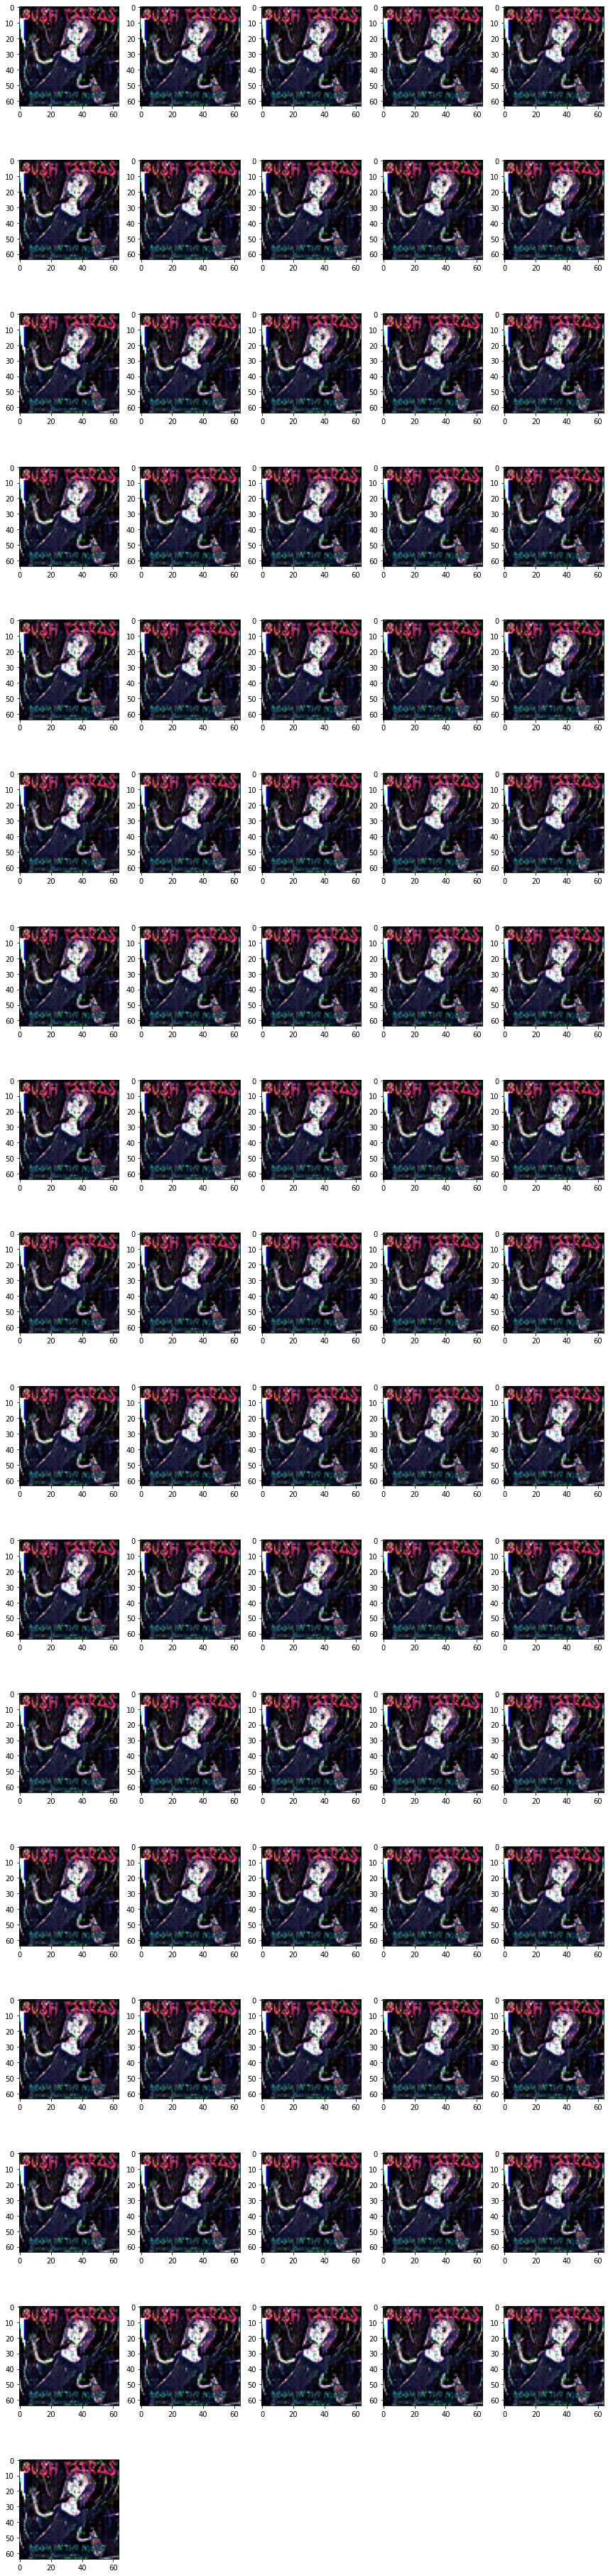

In [33]:
plot_img_samples(im, subplot_dim=(20, 5), figsize=(12, 60))

# **Loss Curve**

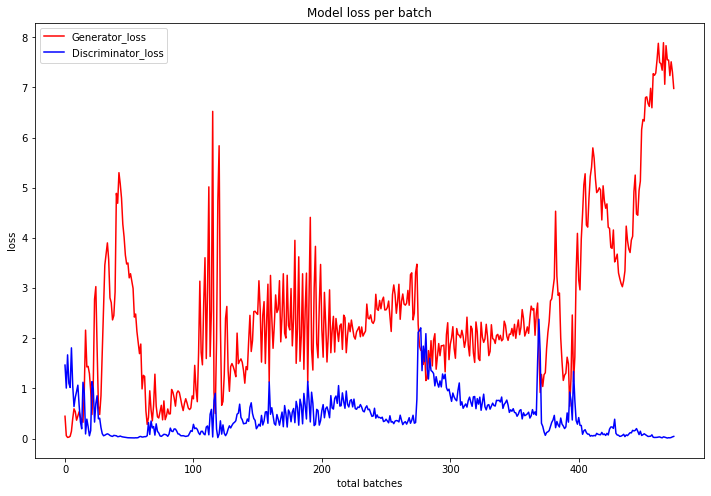

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(G_loss,color='red',label='Generator_loss')
plt.plot(D_loss,color='blue',label='Discriminator_loss')
plt.legend()
plt.xlabel('total batches')
plt.ylabel('loss')
plt.title('Model loss per batch')
plt.show()